In [2]:
import numpy as np
import os
from PIL import Image
import PIL
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def rot90(v):
    return np.array([-v[1], v[0]])

In [4]:
celeba_hq_dir='D:/Dataset/CelebAMask-HQ'
with open(os.path.join(celeba_hq_dir, 'image_list.txt'), 'rt') as file:
    lines = [line.split() for line in file]
    fields = dict()
    for idx, field in enumerate(lines[0]):
        type = int if field.endswith('idx') else str
        fields[field] = [type(line[idx]) for line in lines[1:]]
indices = np.array(fields['idx'])

In [78]:
indices

array([    0,     1,     2, ..., 29997, 29998, 29999])

In [5]:
celeba_dir = 'E:/Dataset/CelebA/img_celeba.7z'
with open(os.path.join(celeba_dir,'anno', 'list_landmarks_celeba.txt'), 'rt') as file:
    landmarks = [[float(value) for value in line.split()[1:]]
                 for line in file.readlines()[2:]]
    landmarks = np.float32(landmarks).reshape(-1, 5, 2)

In [58]:
# Let me know if you found it useful at stian.lode@gmail.com
def edges(window):
    """Splits a window into start and end indices. Will default to have the
    larger padding at the end in case of an odd window.
    """
    start = window//2
    end = window-start
    return (start, end)

def fast_pad_symmetric(values, window, dtype='f8'):
    """A fast version of numpy n-dimensional symmetric pad.
    In contrast to np.pad, this algorithm only allocates memory once, regardless
    of the number of axes padded. Performance for large data sets is vastly
    improved.
    Note: if the requested padding is 0 along all axes, then this algorithm
    returns the original input ndarray.
    Author: Stian Lode stian.lode@gmail.com
    Args:
        values: n-dimensional ndarray
        window: an iterable of length n
    return:
        a numpy ndarray containing the values with each axis padded according
        to the specified window. The padding is a reflection of the data in 
        the input values.
    """
    assert len(values.shape) == len(window) 

    if (window <= 0).all():
        return values

    start, end = edges(window)
    new = np.empty(values.shape + window, dtype=dtype)

    slice_stack = []
    for a, b in zip(start, end):
        slice_stack.append(slice(a, None if b == 0 else -b))

    new[tuple(slice_stack)] = values

    slice_stack = []
    for a,b in zip(start, end):
        if a > 0:
            s_to, s_from = slice(a - 1, None, -1), slice(a, 2 * a, None)
            new[tuple(slice_stack + [s_to])] = new[tuple(slice_stack + [s_from])]

        if b > 0:
            e_to, e_from = slice(-1, -b-1, -1), slice(-2 * b, -b)
            new[tuple(slice_stack + [e_to])] = new[tuple(slice_stack + [e_from])]

        slice_stack.append(slice(None))

    return new

def numpypad(values, window):
    s, e = edges(window)
    return np.pad(values, zip(s, e), mode='symmetric')

In [77]:
def crop_img(img,lm):
    # Choose oriented crop rectangle.
    eye_avg = (lm[0] + lm[1]) * 0.5 + 0.5
    mouth_avg = (lm[3] + lm[4]) * 0.5 + 0.5
    eye_to_eye = lm[1] - lm[0]
    eye_to_mouth = mouth_avg - eye_avg
    x = eye_to_eye - rot90(eye_to_mouth)
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = rot90(x)
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    zoom = 1024 / (np.hypot(*x) * 2)

    # Shrink.
    shrink = int(np.floor(0.5 / zoom))
    if shrink > 1:
        size = (int(np.round(float(img.size[0]) / shrink)),
                int(np.round(float(img.size[1]) / shrink)))
        img = img.resize(size, Image.ANTIALIAS)
        quad /= shrink
        zoom *= shrink

    # Crop.
    border = max(int(np.round(1024 * 0.1 / zoom)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(
        np.ceil(max(quad[:, 0]))), int(np.ceil(max(quad[:, 1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0),
            min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Simulate super-resolution.
    superres = int(np.exp2(np.ceil(np.log2(zoom))))
    if superres > 1:
        img = img.resize(
            (img.size[0] * superres, img.size[1] * superres), PIL.Image.ANTIALIAS)
        quad *= superres
        zoom /= superres

    # Pad.
    pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(
        np.ceil(max(quad[:, 0]))), int(np.ceil(max(quad[:, 1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] -
           img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if max(pad) > border - 4:
        pad = np.maximum(pad, int(np.round(1024 * 0.3 / zoom)))
        img = np.pad(np.float32(img),
                     ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.mgrid[:h, :w, :1]
        mask = 1.0 - np.minimum(np.minimum(np.float32(x) / pad[0], np.float32(
            y) / pad[1]), np.minimum(np.float32(w-1-x) / pad[2], np.float32(h-1-y) / pad[3]))
        blur = 1024 * 0.02 / zoom
        img += (scipy.ndimage.gaussian_filter(img,
                [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.round(img), 0, 255)), 'RGB')
        quad += pad[0:2]

    # Transform.
    img = img.transform((2048,2048), PIL.Image.QUAD,
                        (quad + 0.5).flatten(), PIL.Image.BILINEAR)

    img = img.resize((128, 128))
    return img

In [74]:
idx=138
orig_idx = fields['orig_idx'][idx]
orig_file = fields['orig_file'][idx]
orig_path = os.path.join(celeba_dir, 'img_celeba', orig_file)
img_raw = Image.open(orig_path)
lm = landmarks[orig_idx]

In [81]:
list(zip(fields['orig_idx'],fields['orig_file'],landmarks))[0]

(119613,
 '119614.jpg',
 array([[165., 184.],
        [244., 176.],
        [196., 249.],
        [194., 271.],
        [266., 260.]], dtype=float32))

In [75]:
img = crop_img(img_raw,lm)

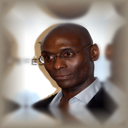

In [76]:
img

In [ ]:
save_dir='D:/Dataset/FFHQ_work/celeba_lr_train/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
img.save(os.path.join(save_dir,str(fields['idx'][idx])+'.jpg'))

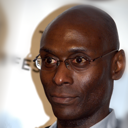

'138.jpg'

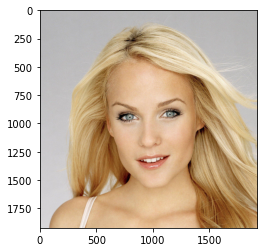

In [201]:
plt.imshow(img)

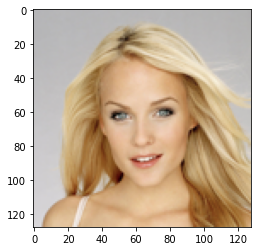

In [203]:
plt.imshow(img)